# Coursework: Mammographic density prediction

In this coursework, you will implement a model for breast tissue density prediction from digital screening mammography data. Mammograms are X‑ray images acquired as part of regular breast cancer screening programmes. Breast tissue density is an important risk factor and is categorised into four classes according to the BI‑RADS (Breast Imaging Reporting and Data System) standard:
- Class A – Almost entirely fatty: The breast is composed mostly of fatty tissue with minimal fibroglandular density.
- Class B – Scattered areas of fibroglandular density: There are some dense areas, but most of the tissue is still fatty.
- Class C – Heterogeneously dense: Many areas of dense tissue are present, which may obscure small masses.
- Class D – Extremely dense: The breast is composed predominantly of dense tissue, making mammographic interpretation and cancer detection more challenging.

Your task is to develop and evaluate a predictive model capable of automatically assigning these density categories from mammographic images. You will be asked to assess the performance of the model across different subgroups, and conduct a model inspection using dimensionality reduction of feature embeddings.

The coursework is divided in the following parts:

* **Part A**: Choose a sensible data augmentation pipeline within the `MammoDataset` class.
* **Part B**: Implement a sensible model for image classification within the `MammoNet` class.
* **Part C**: Conduct a subgroup performance analysis.
* **Part D**: Inspect the trained model by analysing feature embeddings.
* **Part E**: Write a short report about your coursework (using the [provided template](https://www.overleaf.com/read/rkjxjntdfdwr#df7c9e)).

**Important:** Read the text descriptions carefully and look out for hints and comments indicating a specific **TASK**. Make sure to add sufficient documentation and comments to your code.

**Submission:** You are asked to submit two files:
1. You should submit this notebook in `.ipynb` format with *all outputs included*. Please name your file `notebook.ipynb`.
2. You should also submit a short report in `.pdf` format, using [this template](https://www.overleaf.com/read/rkjxjntdfdwr#df7c9e). Please name this file `report.pdf`.

### Your details

Please add your details below. You can work in groups up to two.

Authors: **firstname1 lastname1** & **firstname2 lastname2**

DoC username: **alias1** & **alias2**

### Setup

In [ ]:
# On Google Colab uncomment the following line to install additional libraries
# ! pip install lightning
# ! pip install stocaching

# See the requirements.txt file for more details on the required libraries.
# We recommend using a virtual environment to manage dependencies.
# For example, you can create a virtual environment using venv:
# python3 -m venv myenv
# source myenv/bin/activate
# pip install -r requirements.txt

In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms.v2 as T
import pytorch_lightning as pl
import matplotlib.pyplot as plt
import matplotlib as mpl
import plotly.graph_objs as go
import plotly.express as px
import seaborn as sns

from matplotlib import cm
from ipywidgets import Output, HBox
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn import decomposition
from sklearn.manifold import TSNE
from skimage.io import imread
from skimage.util import img_as_ubyte
from torchmetrics.functional import auroc
from torch.utils.data import DataLoader, Dataset
from torchvision import models
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import ModelCheckpoint, TQDMProgressBar
from stocaching import SharedCache
from torchsampler import ImbalancedDatasetSampler

In [2]:
import os

# Create a cache directory in your data folder (where you have space)
cache_dir = './data/torch_cache'
os.makedirs(cache_dir, exist_ok=True)

# Tell PyTorch to use this directory instead of your home folder
os.environ['TORCH_HOME'] = cache_dir

print(f"PyTorch cache redirected to: {cache_dir}")

PyTorch cache redirected to: ./data/torch_cache


### Data

We make use of the publicly available [RSNA-SMBC dataset](https://registry.opendata.aws/rsna-screening-mammography-breast-cancer-detection/). We have preproceesed this dataset to make it easier to work with. We have reduced the image sizes to 128x96 and simplified the meta information.

Note, unzipping the dataset will take a few minutes, as there almost 30,000 images. Only needs to be done once.

In [3]:
! wget https://www.doc.ic.ac.uk/~bglocker/teaching/mli/rsna-small.zip
! unzip -q rsna-small.zip # Remove -q for verbose output

--2026-02-16 16:04:26--  https://www.doc.ic.ac.uk/~bglocker/teaching/mli/rsna-small.zip
Resolving www.doc.ic.ac.uk (www.doc.ic.ac.uk)... 146.169.13.6
Connecting to www.doc.ic.ac.uk (www.doc.ic.ac.uk)|146.169.13.6|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 285622253 (272M) [application/zip]
Saving to: ‘rsna-small.zip.1’

rsna-small.zip.1    100%[===================>] 272.39M   111MB/s    in 2.5s    

2026-02-16 16:04:29 (111 MB/s) - ‘rsna-small.zip.1’ saved [285622253/285622253]

replace data/rsna-small/meta.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [3]:
DATA_DIR = './data/rsna-small'
CSV_FILE = os.path.join(DATA_DIR, 'meta.csv')
IMAGE_SIZE = (128, 96)
NUM_CLASSES = 4

Let's check the meta information of the dataset.

In [4]:
df_meta = pd.read_csv(CSV_FILE)
df_meta.head()

,image_id,laterality,view,age,cancer,implant,density,machine_id,study_id,split
0,1967300488,L,MLO,60.0,0,0,C,216,10038,training
1,2142944869,L,CC,60.0,0,0,C,216,10038,training
2,850559196,R,MLO,60.0,0,0,C,216,10038,training
3,1350492010,R,CC,60.0,0,0,C,216,10038,training
4,102733848,L,CC,51.0,0,0,C,93,10042,training


Let's visualise some random samples from each density class. You can run this cell repeatedly to see different samples.

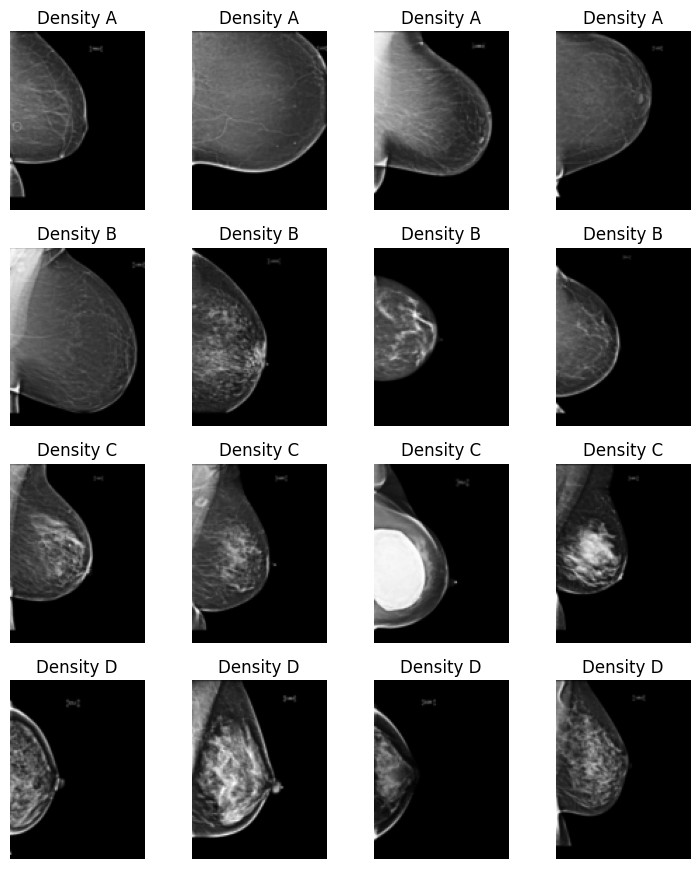

In [5]:
N_PER_CLASS = 4  # Number of images per class to display
CLASSES_DISPLAY = ["A", "B", "C", "D"] # Breast density classes for display

df_meta["img_path"] = [
    os.path.join(
        DATA_DIR, "images",
        str(df_meta.study_id.values[i]),
        str(df_meta.image_id.values[i]) + ".png"
    )
    for i in range(len(df_meta))
]

# display sample images from each class
fig, axes = plt.subplots(len(CLASSES_DISPLAY), N_PER_CLASS, figsize=(1.9 * N_PER_CLASS, 2.2 * len(CLASSES_DISPLAY)))
if N_PER_CLASS == 1: # In case of single column, expand dims
    axes = np.expand_dims(axes, axis=1)

for r, cls in enumerate(CLASSES_DISPLAY):
    sub = df_meta[df_meta["density"] == cls]
    k = min(N_PER_CLASS, len(sub))
    sample_idx = np.random.choice(len(sub), size=k, replace=False)
    samples = sub.iloc[sample_idx]
    for c in range(N_PER_CLASS):
        ax = axes[r, c]
        ax.axis("off")
        if c < k:
            img = imread(samples.iloc[c]["img_path"])
            ax.imshow(img, cmap="gray")
            ax.set_title(f"Density {cls}", fontsize=12)
plt.tight_layout()
plt.show()


## **Part A**: Choose a sensible data augmentation pipeline within the `MammoDataset` class.

We provide a custom [PyTorch Dataset](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html) that manages the RSNA-SMBC dataset.

**TASK:** Implement data augmentation for mammography images. You can use the `torchvision.transforms.v2` module to select a sensible set of photometric and geometric transformations. Report your choices in the coursework report.

In [6]:
class MammoDataset(Dataset):
    def __init__(self, data, image_size, image_normalization, augmentation = False, cache_size = 0):
        self.image_normalization = image_normalization
        self.do_augment = augmentation

        self.photometric_augment = T.Compose([
            T.ColorJitter(brightness=0.2, contrast=0.2),
            T.RandomAdjustSharpness(sharpness_factor=1.5, p=0.5),
        ])

        # Geometric data augmentation
        # Simulates patient positioning variations
        self.geometric_augment = T.Compose([
            # Left/Right flip (density classification should be invariant to laterality)
            T.RandomHorizontalFlip(p=0.5),
            # Affine: Rotation (+/- 15 deg), Translation (10%), Scale (90-110%)
            T.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.9, 1.1)),
            # Ensure the output is strictly the target size
            T.Resize(size=image_size, antialias=True)
        ])
        # load metadata into numpy arrays for faster access
        self.img_paths = data.img_path.to_numpy()
        self.study_ids = data.study_id.to_numpy()
        self.image_ids = data.image_id.to_numpy()
        self.labels = data.labels.to_numpy()

        # cache for preprocessed images to speed up training after the first epoch
        self.cache = None
        self.use_cache = cache_size > 0
        if self.use_cache:
            self.cache = SharedCache(
                size_limit_gib=cache_size,
                dataset_len=self.labels.shape[0],
                data_dims=(1, image_size[0], image_size[1]),
                dtype=torch.float32,
            )

    def preprocess(self, image):
        # breast segmentation using connected components
        image_norm = image - np.min(image)
        image_norm = image_norm / np.max(image_norm)
        thresh = cv2.threshold(img_as_ubyte(image_norm), 5, 255, cv2.THRESH_BINARY)[1]
        nb_components, output, stats, _ = cv2.connectedComponentsWithStats(thresh, connectivity=4)

        # Find the largest non background component.
        max_label, _ = max(
            [(i, stats[i, cv2.CC_STAT_AREA]) for i in range(1, nb_components)],
            key=lambda x: x[1],
        )
        mask = output == max_label
        image[mask == 0] = 0
                
        return image

    def __len__(self):
        return self.labels.shape[0]

    def __getitem__(self, index):
        image = None
        if self.use_cache:
            image = self.cache.get_slot(index)
        
        if image is None:
            img_path = self.img_paths[index]
            image = imread(img_path).astype(np.float32)
            image = self.preprocess(image)
            image = torch.from_numpy(image).unsqueeze(0)            
            
            if self.use_cache:
                self.cache.set_slot(index, image, allow_overwrite=True)

        image = image.repeat(3, 1, 1)
        # normalize intensities to range [0,1]
        image = image / self.image_normalization

        if self.do_augment:
            image = self.photometric_augment(image)
            image = self.geometric_augment(image)

        # convert to 3-channel image to be compatible with pretrained models
        #image = image.repeat(3, 1, 1)
        imagenet_mean = torch.tensor([0.485, 0.456, 0.406], dtype=image.dtype, device=image.device).view(-1,1,1)
        imagenet_std  = torch.tensor([0.229, 0.224, 0.225], dtype=image.dtype, device=image.device).view(-1,1,1)
        image = (image - imagenet_mean) / imagenet_std


        return {'image': image, 'label': self.labels[index], 'study_id': self.study_ids[index], 'image_id': self.image_ids[index]}
    
    def get_labels(self):
        return self.labels


We use a [LightningDataModule](https://lightning.ai/docs/pytorch/stable/data/datamodule.html) for preparing the RSNA-SMBC dataset and its training, validation and test splits. No changes required here but make sure that you understand what is happening within this module.

In [7]:
class MammoDataModule(pl.LightningDataModule):
    def __init__(self, data_dir, csv_file, image_size, batch_size, num_workers):
        super().__init__()
        self.data_dir = data_dir
        self.image_size = image_size
        self.batch_size = batch_size
        self.num_workers = num_workers

        # load metadata
        self.data = pd.read_csv(csv_file)

        # construct image paths from metadata
        self.data['img_path'] = [os.path.join(self.data_dir, 'images', str(self.data.study_id.values[idx]), str(self.data.image_id.values[idx]) + '.png') for idx in range(0, len(self.data))]

        # Define image labels based on breast density classes
        self.data['labels'] = self.data['density']
        self.data.loc[self.data['labels'] == 'A', 'labels'] = 0
        self.data.loc[self.data['labels'] == 'B', 'labels'] = 1
        self.data.loc[self.data['labels'] == 'C', 'labels'] = 2
        self.data.loc[self.data['labels'] == 'D', 'labels'] = 3

        # Use pre-defined splits to separate data into train, val and testing
        self.train_data = self.data[self.data['split'] == 'training']
        self.val_data = self.data[self.data['split'] == 'validation']
        self.test_data = self.data[self.data['split'] == 'test']

        # create dataset objects for each split
        self.train_set = MammoDataset(self.train_data, self.image_size, image_normalization=65535.0, augmentation=True, cache_size=2)
        self.val_set = MammoDataset(self.val_data, self.image_size, image_normalization=65535.0, augmentation=False, cache_size=0.5)
        self.test_set = MammoDataset(self.test_data, self.image_size, image_normalization=65535.0, augmentation=False)

        # print dataset statistics
        train_labels = self.train_set.get_labels()
        train_class_count = np.array([len(np.where(train_labels == t)[0]) for t in np.unique(train_labels)])

        val_labels = self.val_set.get_labels()        
        val_class_count = np.array([len(np.where(val_labels == t)[0]) for t in np.unique(val_labels)])

        test_labels = self.test_set.get_labels()        
        test_class_count = np.array([len(np.where(test_labels == t)[0]) for t in np.unique(test_labels)])

        print('samples (train): ',len(self.train_set))
        print('samples (val):   ',len(self.val_set))
        print('samples (test):  ',len(self.test_set))
        print('class counts (train): ', train_class_count)
        print('class counts (val):   ', val_class_count)
        print('class counts (test):  ', test_class_count)
        print('class % (train): ', np.array([f"{x:.2f}" for x in np.array(train_class_count/len(train_labels)*100.0)]))
        print('class % (val):   ', np.array([f"{x:.2f}" for x in np.array(val_class_count/len(val_labels)*100.0)]))
        print('class % (test):  ', np.array([f"{x:.2f}" for x in np.array(test_class_count/len(test_labels)*100.0)]))

    def train_dataloader(self):
        # we use ImbalancedDatasetSampler to handle class imbalance in the training set
        return DataLoader(dataset=self.train_set, batch_size=self.batch_size, sampler=ImbalancedDatasetSampler(self.train_set), num_workers=self.num_workers, pin_memory=True)

    def val_dataloader(self):
        return DataLoader(dataset=self.val_set, batch_size=self.batch_size, shuffle=False, num_workers=self.num_workers)

    def test_dataloader(self):
        return DataLoader(dataset=self.test_set, batch_size=self.batch_size, shuffle=False, num_workers=self.num_workers)

## **Part B**: Implement a sensible model for image classification within the `MammoNet` class.

We use a [LightningModule](https://lightning.ai/docs/pytorch/stable/common/lightning_module.html) for implementing the model and its training and testing steps.

**TASK:** Implement and try out different models suitable for the breast density prediction problem. Check out the `torchvision.models` module. Report your choices in the coursework report.

In [ ]:
class MammoNet(pl.LightningModule):
    def __init__(self, num_classes, learning_rate=0.0001, dropout_rate=0.5):
        super().__init__()
        self.num_classes = num_classes
        self.lr = learning_rate
        self.dropout_rate = dropout_rate
        
        self.backbone = models.resnet18(pretrained=True)
        
        # Get the number of features from the backbone (512 for ResNet18)
        num_features = self.backbone.fc.in_features
        
        # Remove the original fully connected layer
        # We'll replace it with our custom classifier
        self.backbone.fc = nn.Identity()

        # Custom classifier head with regularization
        # Multi-layer design allows learning of complex decision boundaries
        # Dropout prevents overfitting on the relatively small medical dataset
        self.classifier = nn.Sequential(
            # First hidden layer: 512 -> 256
            nn.Linear(num_features, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate),
            
            # Second hidden layer: 256 -> 128
            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate),
            
            # Output layer: 128 -> num_classes
            nn.Linear(128, num_classes)
        )
        
        self.model = nn.Sequential(self.backbone, self.classifier)

    def forward(self, x, return_features=False):

        # Extract features from backbone (shape: batch_size x 512)
        features = self.backbone(x)
        
        # Classify using custom head (shape: batch_size x num_classes)
        logits = self.classifier(features)
        
        if return_features:
            return features, logits
        return logits
        
    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(  # Switch to AdamW
        self.model.parameters(), 
        lr=self.lr,
        weight_decay=0.001  # Add regularization
        )
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer, T_max=self.trainer.max_epochs, eta_min=1e-6
        )
        return [optimizer], [scheduler]

    def get_class_weights(labels):
        from collections import Counter
        counts = Counter(labels)
        total = len(labels)
        weights = [total / (len(counts) * counts[i]) for i in range(len(counts))]
        return torch.FloatTensor(weights)

    def process_batch(self, batch):
        img, lab = batch['image'], batch['label']
        out = self.forward(img)
        prd = torch.softmax(out, dim=1)
        loss = F.cross_entropy(out, lab)#, label_smoothing=0.1)
        return loss, prd, lab

    def on_train_epoch_start(self):
        self.train_preds = []
        self.train_trgts = []

    def training_step(self, batch, batch_idx):
        loss, prd, lab = self.process_batch(batch)
        self.log('train_loss', loss, batch_size=lab.shape[0])
        self.train_preds.append(prd.detach().cpu())
        self.train_trgts.append(lab.detach().cpu())
        if batch_idx == 0:
            images = batch['image'][0:4, ...].detach().cpu()
            grid = torchvision.utils.make_grid(images, nrow=2, normalize=True)
            self.logger.experiment.add_image('images', grid, self.global_step)
        return loss

    def on_train_epoch_end(self):
        self.train_preds = torch.cat(self.train_preds, dim=0)
        self.train_trgts = torch.cat(self.train_trgts, dim=0)
        auc = auroc(self.train_preds, self.train_trgts, num_classes=self.num_classes, average='macro', task='multiclass')
        self.log('train_auc', auc)
        self.train_preds = []
        self.train_trgts = []

    def on_validation_epoch_start(self):
        self.val_preds = []
        self.val_trgts = []

    def validation_step(self, batch, batch_idx):
        loss, prd, lab = self.process_batch(batch)
        self.log('val_loss', loss, batch_size=lab.shape[0])
        self.val_preds.append(prd.detach().cpu())
        self.val_trgts.append(lab.detach().cpu())

    def on_validation_epoch_end(self):
        self.val_preds = torch.cat(self.val_preds, dim=0)
        self.val_trgts = torch.cat(self.val_trgts, dim=0)
        auc = auroc(self.val_preds, self.val_trgts, num_classes=self.num_classes, average='macro', task='multiclass')
        self.log('val_auc', auc)
        self.val_preds = []
        self.val_trgts = []

    def on_test_epoch_start(self):
        self.test_preds = []
        self.test_trgts = []
        self.test_study_ids = []
        self.test_image_ids = []

    def test_step(self, batch, batch_idx):
        loss, prd, lab = self.process_batch(batch)
        self.log('test_loss', loss, batch_size=lab.shape[0])
        self.test_preds.append(prd.detach().cpu())
        self.test_trgts.append(lab.detach().cpu())        
        self.test_study_ids.append(batch['study_id'].detach().cpu())
        self.test_image_ids.append(batch['image_id'].detach().cpu())

    def on_test_epoch_end(self):
        self.test_preds = torch.cat(self.test_preds, dim=0)
        self.test_trgts = torch.cat(self.test_trgts, dim=0)
        auc = auroc(self.test_preds, self.test_trgts, num_classes=self.num_classes, average='macro', task='multiclass')
        self.log('test_auc', auc)
        
    

### Training

We use the PyTorch Lightning [Trainer](https://lightning.ai/docs/pytorch/stable/common/trainer.html) for easy training and testing. You may need to adjust the number of epochs, but otherwise you should be able to just run the cell and wait for the training to complete.

**TASK:** Adjust the number of epochs if needed. Report any observations about the training in your coursework report (you may want to check training and validation curves via Tensorboard).

In [16]:
pl.seed_everything(42, workers=True)

output_base = './output/'
output_name = 'mammo-net'
output_dir = os.path.join(output_base, output_name)

data = MammoDataModule(data_dir=DATA_DIR, csv_file=CSV_FILE, image_size=IMAGE_SIZE, batch_size=256, num_workers=4)

#model = MammoNet(num_classes=NUM_CLASSES, learning_rate=0.001)
model = MammoNet(num_classes=NUM_CLASSES, learning_rate=0.0001, dropout_rate=0.2)


trainer = pl.Trainer(
    max_epochs=20,
    accelerator='auto',
    devices=1,
    gradient_clip_val=1.0,  # Add stability
    log_every_n_steps=5,
    logger=TensorBoardLogger(save_dir=output_base, name=output_name),
    callbacks=[ModelCheckpoint(monitor="val_auc", mode='max'), TQDMProgressBar(refresh_rate=10)],
)
trainer.fit(model=model, datamodule=data)

Seed set to 42


Dataset size (1.0 GiB) fits in cache limit (2 GiB). Allocating space to cache all 21204 samples.
Dataset size (0.1 GiB) fits in cache limit (0.5 GiB). Allocating space to cache all 2368 samples.
samples (train):  21204
samples (val):    2368
samples (test):   5865
class counts (train):  [2224 9057 8856 1067]
class counts (val):    [ 247 1034  938  149]
class counts (test):   [ 628 2548 2368  321]
class % (train):  ['10.49' '42.71' '41.77' '5.03']
class % (val):    ['10.43' '43.67' '39.61' '6.29']
class % (test):   ['10.71' '43.44' '40.38' '5.47']


/vol/gpudata/jk625-ml-imaging/mammographic-dencity-prediction/venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/vol/gpudata/jk625-ml-imaging/mammographic-dencity-prediction/venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automati

┏━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name       ┃ Type       ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ backbone   │ ResNet     │ 11.2 M │ train │     0 │
│ 1 │ classifier │ Sequential │  164 K │ train │     0 │
│ 2 │ model      │ Sequential │ 11.3 M │ train │     0 │
└───┴────────────┴────────────┴────────┴───────┴───────┘

Trainable params: 11.3 M                                                                                           
Non-trainable params: 0                                                                                            
Total params: 11.3 M                                                                                               
Total estimated model params size (MB): 45                                                                         
Modules in train mode: 77                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


### Validation

Evaluate the trained model with the best checkpoint on the validation data and report the classification performance.

**TASK:** You should report the validation performance and some information about the model checkpoint in the coursework report (at what epoch/iteration did you find the best checkpoint).

In [17]:
trainer.validate(model=model, datamodule=data, ckpt_path=trainer.checkpoint_callback.best_model_path)

Restoring states from the checkpoint path at ./output/mammo-net/version_38/checkpoints/epoch=1-step=166.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at ./output/mammo-net/version_38/checkpoints/epoch=1-step=166.ckpt


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_auc          │    0.9289186000823975     │
│         val_loss          │    0.5936716794967651     │
└───────────────────────────┴───────────────────────────┘

[{'val_loss': 0.5936716794967651, 'val_auc': 0.9289186000823975}]

### Testing

Evaluate the trained model with the best checkpoint on the test data and report the classification performance.

**TASK:** You should report the test performance in the coursework report.

In [18]:
def save_predictions(model, output_fname):
    std_ids = [id.numpy() for sublist in model.test_study_ids for id in sublist]
    img_ids = [id.numpy() for sublist in model.test_image_ids for id in sublist]
    cols_names = ['class_' + str(i) for i in range(0, NUM_CLASSES)]
    df = pd.DataFrame(data=model.test_preds.numpy(), columns=cols_names)    
    df['target'] = model.test_trgts.numpy()
    df['study_id'] = std_ids
    df['image_id'] = img_ids
    df.to_csv(output_fname, index=False)

In [19]:
trainer.test(model=model, datamodule=data, ckpt_path=trainer.checkpoint_callback.best_model_path)
save_predictions(model=model, output_fname=os.path.join(output_dir, 'predictions.csv'))

Restoring states from the checkpoint path at ./output/mammo-net/version_38/checkpoints/epoch=1-step=166.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at ./output/mammo-net/version_38/checkpoints/epoch=1-step=166.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_auc          │    0.9188048243522644     │
│         test_loss         │    0.6208400130271912     │
└───────────────────────────┴───────────────────────────┘

## **Part C**: Conduct a subgroup performance analysis.

The code below allows you to check the model performance by plotting the [ROC curves](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html) and calculating the per-class [AUC](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.auc.html) metrics over the whole test set.

**TASK:** Using different attributes from the meta information, conduct several subgroup performance analyses, and report the results in the coursework report. Note any interesting observations.

In [13]:
df_pred = pd.read_csv(os.path.join(output_dir, 'predictions.csv'))

In [14]:
class_columns = [col for col in df_pred.columns if col.startswith('class_')]
preds = np.stack([df_pred[col] for col in class_columns]).T
targets = np.array(df_pred['target'])

roc_results = {}

for i, class_name in enumerate(class_columns):
    pos_label = i
    y = np.array(targets)
    y[targets != pos_label] = 0
    y[targets == pos_label] = 1

    fpr, tpr, _ = roc_curve(y, preds[:, pos_label])
    roc_auc = auc(fpr, tpr)

    roc_results[class_name] = {
        'fpr': fpr,
        'tpr': tpr,
        'roc_auc': roc_auc
    }

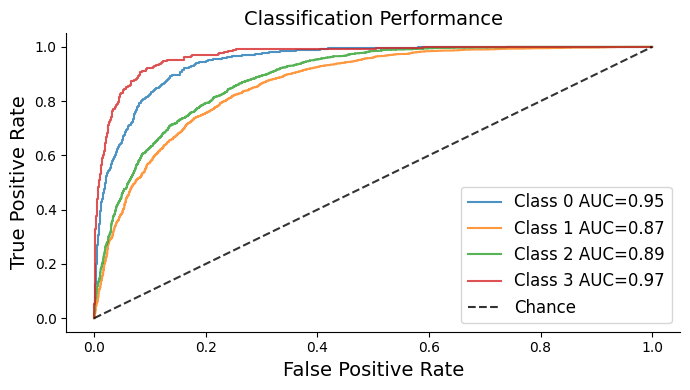

In [15]:
fig, ax = plt.subplots(figsize=(7, 4))

for i, (class_name, metrics) in enumerate(roc_results.items()):
    label = f"Class {i} AUC={metrics['roc_auc']:.2f}"
    plt.plot(metrics['fpr'], metrics['tpr'], lw=1.5, alpha=.8, label=label)

ax.plot([0, 1], [0, 1], linestyle='--', lw=1.5, color='k', label='Chance', alpha=.8)
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.legend(loc="lower right", fontsize=12)
plt.title('Classification Performance', fontsize=14)
ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05])
ax.spines[['right', 'top']].set_visible(False)
plt.tight_layout()

PART C: COMPREHENSIVE SUBGROUP PERFORMANCE ANALYSIS

SUBGROUP ANALYSIS 1: AGE GROUPS

1. Overall Accuracy by Age Group:
           Correct  Total  Accuracy  N_samples
age_group                                     
<40            155    214    0.7243        214
40-50         1093   1518    0.7200       1518
50-60         1109   1550    0.7155       1550
60-70         1207   1680    0.7185       1680
70+            626    895    0.6994        895

2. Per-Class Distribution by Age:
target         0      1      2     3
age_group                           
<40         7.48  54.21  35.05  3.27
40-50      11.33  41.37  41.24  6.06
50-60      13.03  41.74  39.35  5.87
60-70       9.70  45.30  38.87  6.13
70+         8.38  43.58  44.92  3.13

3. Accuracy by Age and True Class:
age_group  target
<40        0         0.6250
           1         0.6207
           2         0.8800
           3         1.0000
40-50      0         0.7209
           1         0.6338
           2         0.8067
       

/tmp/ipykernel_1997605/3905392447.py:51: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_perf = df_results.groupby('age_group').agg({
/tmp/ipykernel_1997605/3905392447.py:71: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_class_acc = df_results.groupby(['age_group', 'target'])['correct'].mean()
/tmp/ipykernel_1997605/3905392447.py:78: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_stats = df_results.groupby('age_


✓ Visualization saved: subgroup_analysis_age.png


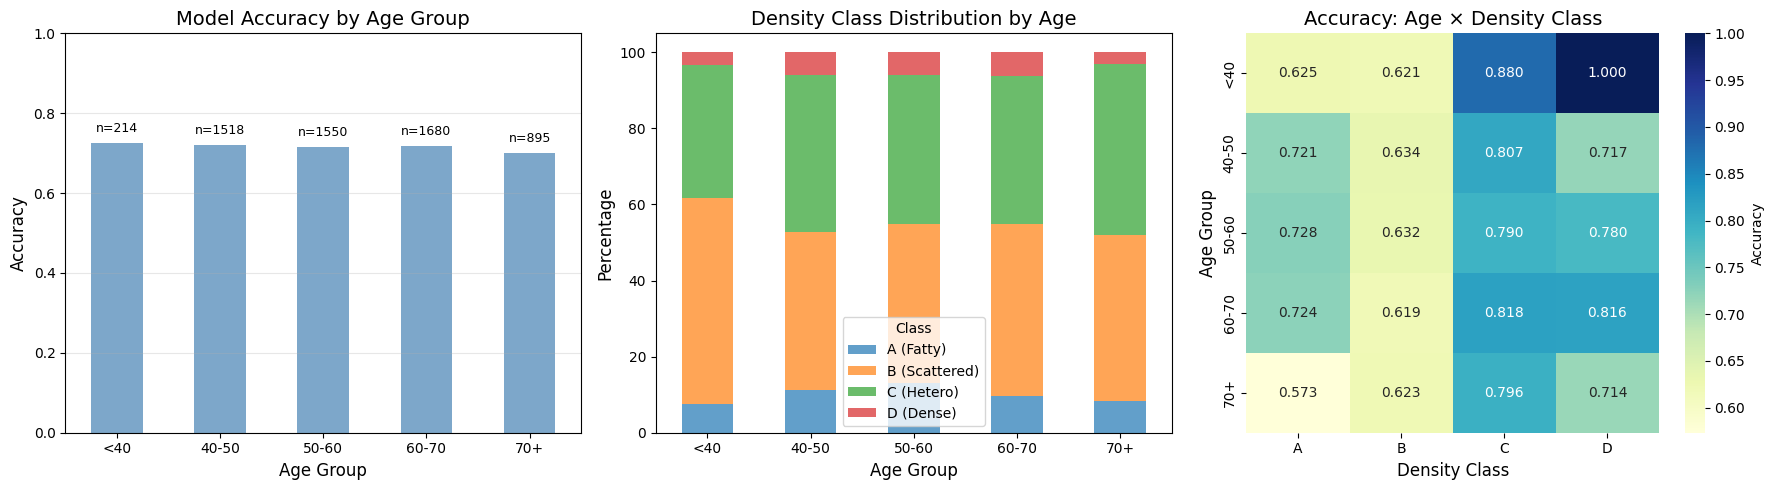


SUBGROUP ANALYSIS 2: BREAST LATERALITY (Left vs Right)

1. Overall Accuracy by Laterality:
            Correct  Total  Accuracy
laterality                          
L              2089   2917    0.7161
R              2108   2948    0.7151

2. Accuracy by Laterality and Class:
laterality  target
L           0         0.7003
            1         0.6206
            2         0.8152
            3         0.7791
R           0         0.7076
            1         0.6335
            2         0.7975
            3         0.7651
Name: correct, dtype: float64

3. Chi-square test for laterality difference:
   p-value = 0.9496
   ✓ No significant difference (good - no bias)

✓ Visualization saved: subgroup_analysis_laterality.png


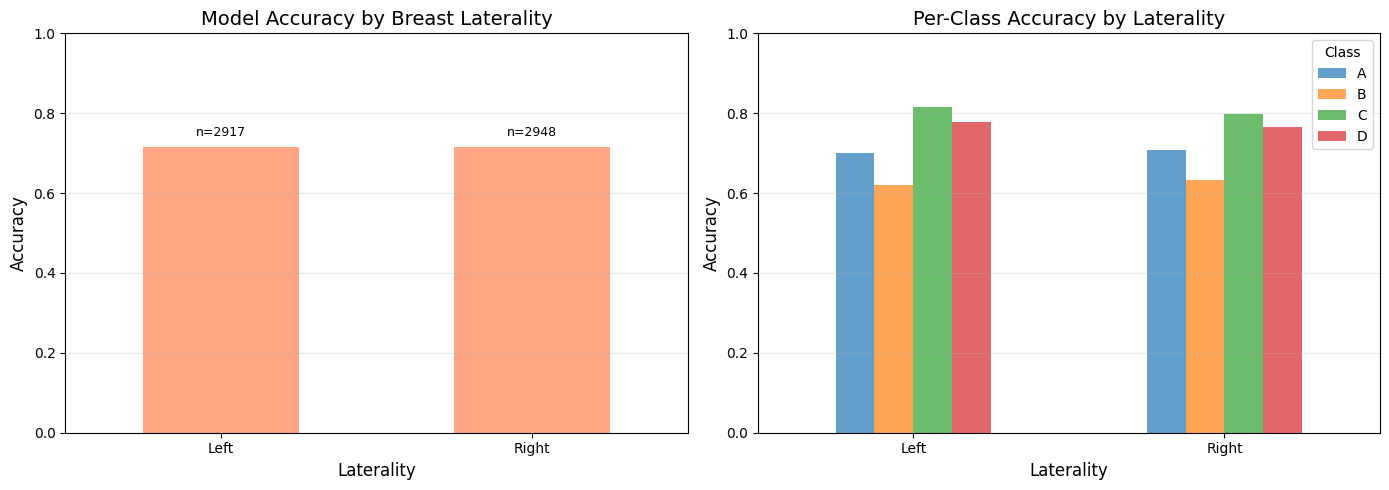


SUBGROUP ANALYSIS 3: VIEW POSITION (CC vs MLO)

1. Overall Accuracy by View:
      Correct  Total  Accuracy
view                          
CC       2016   2835    0.7111
MLO      2181   3030    0.7198

2. Accuracy by View and Class:
view  target
CC    0         0.6948
      1         0.6287
      2         0.7990
      3         0.7484
MLO   0         0.7125
      1         0.6258
      2         0.8129
      3         0.7952
Name: correct, dtype: float64

✓ Visualization saved: subgroup_analysis_view.png


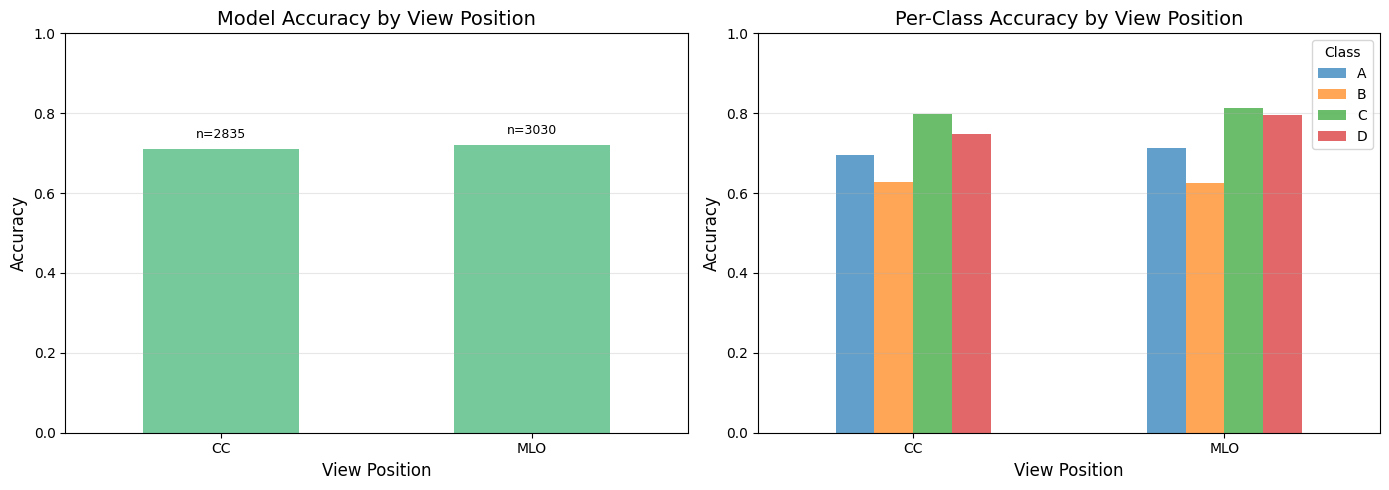


SPECIAL ANALYSIS: WHY ARE CLASSES 1 & 2 HARDER?

1. Confusion Matrix:
        Pred A  Pred B  Pred C  Pred D
True A     442     181       3       2
True B     315    1598     631       4
True C       9     253    1909     197
True D       0       2      71     248

2. Normalized Confusion Matrix (%):
        Pred A  Pred B  Pred C  Pred D
True A   70.38   28.82    0.48    0.32
True B   12.36   62.72   24.76    0.16
True C    0.38   10.68   80.62    8.32
True D    0.00    0.62   22.12   77.26

3. Common Confusions:
   181 cases: True A → Predicted B (28.8%)
   315 cases: True B → Predicted A (12.4%)
   631 cases: True B → Predicted C (24.8%)
   253 cases: True C → Predicted B (10.7%)
    71 cases: True D → Predicted C (22.1%)

4. Key Observation:
   → Classes 1 (B) and 2 (C) are 'in-between' categories
   → They represent transition zones in breast density
   → Even human radiologists show high inter-reader variability here!
   → Most confusions are with ADJACENT classes (B↔C), not dis

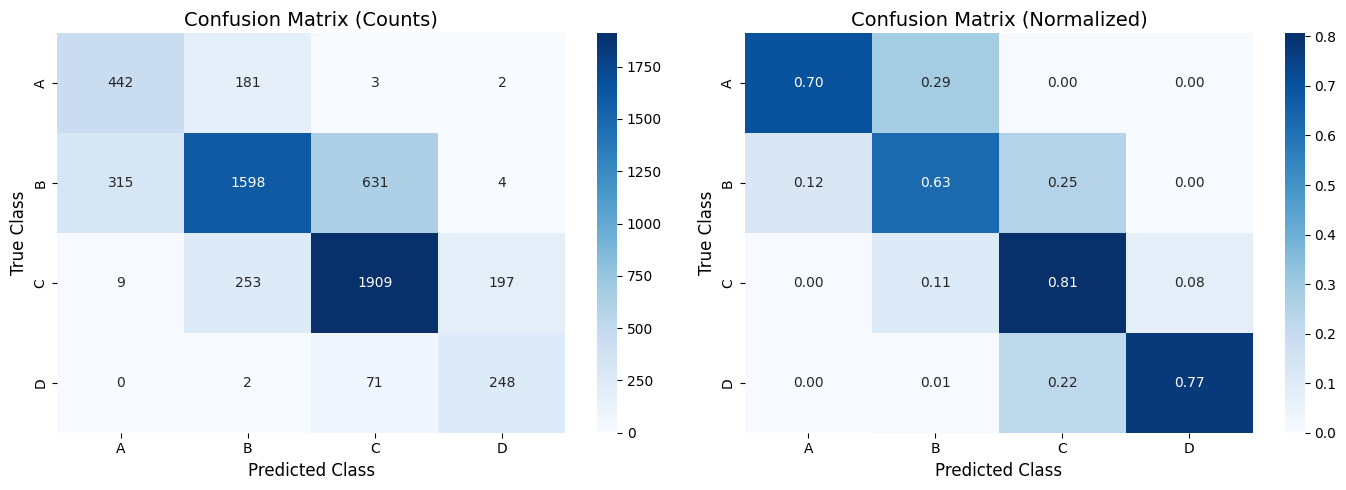


FAIRNESS SUMMARY

Overall Accuracy: 0.7156

Subgroup Performance:

1. Age Groups:
   <40: 0.7243 (+0.0087)
   40-50: 0.7200 (+0.0044)
   50-60: 0.7155 (-0.0001)
   60-70: 0.7185 (+0.0029)
   70+: 0.6994 (-0.0162)
   Max difference: 0.0249

2. Laterality:
   L: 0.7161 (+0.0005)
   R: 0.7151 (-0.0005)
   Max difference: 0.0011

3. View Position:
   CC: 0.7111 (-0.0045)
   MLO: 0.7198 (+0.0042)
   Max difference: 0.0087

FAIRNESS ASSESSMENT
✓ EXCELLENT fairness (max disparity: 0.0249 < 5%)
  Model performs consistently across all subgroups!

Interpretation:
  • Small differences (<5%) are expected and acceptable
  • Age differences reflect natural density distribution changes
  • Laterality should show minimal difference (model shouldn't care L vs R)
  • View differences reflect anatomical information in each projection

PART C COMPLETE!

Generated visualizations:
  1. subgroup_analysis_age.png
  2. subgroup_analysis_laterality.png
  3. subgroup_analysis_view.png
  4. confusion_matrix_an

/tmp/ipykernel_1997605/3905392447.py:356: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_acc = df_results.groupby('age_group')['correct'].mean()


In [17]:
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, balanced_accuracy_score


# =============================================================================
# PART C: COMPREHENSIVE SUBGROUP ANALYSIS
# =============================================================================

def prepare_results_dataframe(df_pred, df_meta):
    """
    Merge predictions with metadata for subgroup analysis
    
    Args:
        df_pred: DataFrame with predictions (columns: class_0, class_1, class_2, class_3, target)
        df_meta: DataFrame with metadata (age, laterality, view, etc.)
    
    Returns:
        DataFrame with predictions and metadata
    """
    # Get predicted class (argmax of probabilities)
    class_columns = [col for col in df_pred.columns if col.startswith('class_')]
    df_pred['predicted_class'] = df_pred[class_columns].values.argmax(axis=1)
    df_pred['correct'] = (df_pred['predicted_class'] == df_pred['target']).astype(int)
    
    # Merge with metadata (assuming df_meta has image_id or study_id to merge on)
    # Adjust this based on your actual data structure
    df_results = pd.merge(df_pred, df_meta, left_index=True, right_index=True, how='left')
    
    return df_results


# =============================================================================
# 1. SUBGROUP ANALYSIS BY AGE
# =============================================================================

def analyze_by_age(df_results):
    """Analyze performance across age groups"""
    
    print("\n" + "="*70)
    print("SUBGROUP ANALYSIS 1: AGE GROUPS")
    print("="*70)
    
    # Create age bins
    df_results['age_group'] = pd.cut(
        df_results['age'], 
        bins=[0, 40, 50, 60, 70, 100],
        labels=['<40', '40-50', '50-60', '60-70', '70+']
    )
    
    # Overall performance by age
    age_perf = df_results.groupby('age_group').agg({
        'correct': ['sum', 'count', 'mean'],
        'target': 'count'
    }).round(4)
    age_perf.columns = ['Correct', 'Total', 'Accuracy', 'N_samples']
    
    print("\n1. Overall Accuracy by Age Group:")
    print(age_perf)
    
    # Per-class performance by age
    print("\n2. Per-Class Distribution by Age:")
    age_class_dist = pd.crosstab(
        df_results['age_group'], 
        df_results['target'], 
        normalize='index'
    ) * 100
    print(age_class_dist.round(2))
    
    # Accuracy per class per age group
    print("\n3. Accuracy by Age and True Class:")
    age_class_acc = df_results.groupby(['age_group', 'target'])['correct'].mean()
    print(age_class_acc.round(4))
    
    # Visualizations
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # Plot 1: Accuracy by age group
    age_stats = df_results.groupby('age_group')['correct'].agg(['mean', 'count'])
    age_stats['mean'].plot(kind='bar', ax=axes[0], color='steelblue', alpha=0.7)
    axes[0].set_xlabel('Age Group', fontsize=12)
    axes[0].set_ylabel('Accuracy', fontsize=12)
    axes[0].set_title('Model Accuracy by Age Group', fontsize=14)
    axes[0].set_ylim([0, 1])
    axes[0].grid(True, alpha=0.3, axis='y')
    for i, (idx, row) in enumerate(age_stats.iterrows()):
        axes[0].text(i, row['mean'] + 0.02, f"n={int(row['count'])}", 
                    ha='center', va='bottom', fontsize=9)
    axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=0)
    
    # Plot 2: Class distribution by age
    age_class_dist.plot(kind='bar', stacked=True, ax=axes[1], alpha=0.7)
    axes[1].set_xlabel('Age Group', fontsize=12)
    axes[1].set_ylabel('Percentage', fontsize=12)
    axes[1].set_title('Density Class Distribution by Age', fontsize=14)
    axes[1].legend(title='Class', labels=['A (Fatty)', 'B (Scattered)', 'C (Hetero)', 'D (Dense)'])
    axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=0)
    
    # Plot 3: Heatmap of accuracy by age and class
    pivot_data = df_results.pivot_table(
        values='correct', 
        index='age_group', 
        columns='target', 
        aggfunc='mean'
    )
    sns.heatmap(pivot_data, annot=True, fmt='.3f', cmap='YlGnBu', 
                cbar_kws={'label': 'Accuracy'}, ax=axes[2])
    axes[2].set_xlabel('Density Class', fontsize=12)
    axes[2].set_ylabel('Age Group', fontsize=12)
    axes[2].set_title('Accuracy: Age × Density Class', fontsize=14)
    axes[2].set_xticklabels(['A', 'B', 'C', 'D'])
    
    plt.tight_layout()
    plt.savefig('subgroup_analysis_age.png', dpi=150, bbox_inches='tight')
    print("\n✓ Visualization saved: subgroup_analysis_age.png")
    plt.show()
    
    return age_perf


# =============================================================================
# 2. SUBGROUP ANALYSIS BY LATERALITY
# =============================================================================

def analyze_by_laterality(df_results):
    """Analyze performance by breast side (L vs R)"""
    
    print("\n" + "="*70)
    print("SUBGROUP ANALYSIS 2: BREAST LATERALITY (Left vs Right)")
    print("="*70)
    
    # Overall performance by laterality
    lat_perf = df_results.groupby('laterality').agg({
        'correct': ['sum', 'count', 'mean']
    }).round(4)
    lat_perf.columns = ['Correct', 'Total', 'Accuracy']
    
    print("\n1. Overall Accuracy by Laterality:")
    print(lat_perf)
    
    # Per-class performance
    print("\n2. Accuracy by Laterality and Class:")
    lat_class_acc = df_results.groupby(['laterality', 'target'])['correct'].mean()
    print(lat_class_acc.round(4))
    
    # Statistical test: is there significant difference?
    from scipy.stats import chi2_contingency
    contingency = pd.crosstab(df_results['laterality'], df_results['correct'])
    chi2, p_value, dof, expected = chi2_contingency(contingency)
    print(f"\n3. Chi-square test for laterality difference:")
    print(f"   p-value = {p_value:.4f}")
    if p_value < 0.05:
        print("   ⚠️  Significant difference detected!")
    else:
        print("   ✓ No significant difference (good - no bias)")
    
    # Visualization
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Plot 1: Overall accuracy
    lat_stats = df_results.groupby('laterality')['correct'].agg(['mean', 'count'])
    lat_stats['mean'].plot(kind='bar', ax=axes[0], color='coral', alpha=0.7)
    axes[0].set_xlabel('Laterality', fontsize=12)
    axes[0].set_ylabel('Accuracy', fontsize=12)
    axes[0].set_title('Model Accuracy by Breast Laterality', fontsize=14)
    axes[0].set_ylim([0, 1])
    axes[0].grid(True, alpha=0.3, axis='y')
    for i, (idx, row) in enumerate(lat_stats.iterrows()):
        axes[0].text(i, row['mean'] + 0.02, f"n={int(row['count'])}", 
                    ha='center', va='bottom', fontsize=9)
    axes[0].set_xticklabels(['Left', 'Right'], rotation=0)
    
    # Plot 2: Per-class accuracy by laterality
    pivot_data = df_results.pivot_table(
        values='correct', 
        index='laterality', 
        columns='target', 
        aggfunc='mean'
    )
    pivot_data.plot(kind='bar', ax=axes[1], alpha=0.7)
    axes[1].set_xlabel('Laterality', fontsize=12)
    axes[1].set_ylabel('Accuracy', fontsize=12)
    axes[1].set_title('Per-Class Accuracy by Laterality', fontsize=14)
    axes[1].legend(title='Class', labels=['A', 'B', 'C', 'D'])
    axes[1].set_xticklabels(['Left', 'Right'], rotation=0)
    axes[1].set_ylim([0, 1])
    axes[1].grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.savefig('subgroup_analysis_laterality.png', dpi=150, bbox_inches='tight')
    print("\n✓ Visualization saved: subgroup_analysis_laterality.png")
    plt.show()
    
    return lat_perf


# =============================================================================
# 3. SUBGROUP ANALYSIS BY VIEW POSITION
# =============================================================================

def analyze_by_view(df_results):
    """Analyze performance by mammography view (CC vs MLO)"""
    
    print("\n" + "="*70)
    print("SUBGROUP ANALYSIS 3: VIEW POSITION (CC vs MLO)")
    print("="*70)
    
    # Overall performance by view
    view_perf = df_results.groupby('view').agg({
        'correct': ['sum', 'count', 'mean']
    }).round(4)
    view_perf.columns = ['Correct', 'Total', 'Accuracy']
    
    print("\n1. Overall Accuracy by View:")
    print(view_perf)
    
    # Per-class performance
    print("\n2. Accuracy by View and Class:")
    view_class_acc = df_results.groupby(['view', 'target'])['correct'].mean()
    print(view_class_acc.round(4))
    
    # Visualization
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Plot 1: Overall accuracy
    view_stats = df_results.groupby('view')['correct'].agg(['mean', 'count'])
    view_stats['mean'].plot(kind='bar', ax=axes[0], color='mediumseagreen', alpha=0.7)
    axes[0].set_xlabel('View Position', fontsize=12)
    axes[0].set_ylabel('Accuracy', fontsize=12)
    axes[0].set_title('Model Accuracy by View Position', fontsize=14)
    axes[0].set_ylim([0, 1])
    axes[0].grid(True, alpha=0.3, axis='y')
    for i, (idx, row) in enumerate(view_stats.iterrows()):
        axes[0].text(i, row['mean'] + 0.02, f"n={int(row['count'])}", 
                    ha='center', va='bottom', fontsize=9)
    axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=0)
    
    # Plot 2: Per-class accuracy by view
    pivot_data = df_results.pivot_table(
        values='correct', 
        index='view', 
        columns='target', 
        aggfunc='mean'
    )
    pivot_data.plot(kind='bar', ax=axes[1], alpha=0.7)
    axes[1].set_xlabel('View Position', fontsize=12)
    axes[1].set_ylabel('Accuracy', fontsize=12)
    axes[1].set_title('Per-Class Accuracy by View Position', fontsize=14)
    axes[1].legend(title='Class', labels=['A', 'B', 'C', 'D'])
    axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=0)
    axes[1].set_ylim([0, 1])
    axes[1].grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.savefig('subgroup_analysis_view.png', dpi=150, bbox_inches='tight')
    print("\n✓ Visualization saved: subgroup_analysis_view.png")
    plt.show()
    
    return view_perf


# =============================================================================
# 4. CONFUSION ANALYSIS FOR CLASSES 1 & 2
# =============================================================================

def analyze_confused_classes(df_results):
    """
    Deep dive into Classes 1 & 2 (B & C) which have lower AUC
    """
    
    print("\n" + "="*70)
    print("SPECIAL ANALYSIS: WHY ARE CLASSES 1 & 2 HARDER?")
    print("="*70)
    
    # Confusion matrix
    cm = confusion_matrix(df_results['target'], df_results['predicted_class'])
    
    print("\n1. Confusion Matrix:")
    cm_df = pd.DataFrame(cm, 
                         index=['True A', 'True B', 'True C', 'True D'],
                         columns=['Pred A', 'Pred B', 'Pred C', 'Pred D'])
    print(cm_df)
    
    # Normalized confusion matrix
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    print("\n2. Normalized Confusion Matrix (%):")
    cm_norm_df = pd.DataFrame(cm_norm * 100, 
                              index=['True A', 'True B', 'True C', 'True D'],
                              columns=['Pred A', 'Pred B', 'Pred C', 'Pred D'])
    print(cm_norm_df.round(2))
    
    # Analyze misclassifications
    print("\n3. Common Confusions:")
    for true_class in range(4):
        for pred_class in range(4):
            if true_class != pred_class and cm[true_class, pred_class] > 0:
                pct = cm_norm[true_class, pred_class] * 100
                if pct > 10:  # Only show significant confusions
                    class_names = ['A', 'B', 'C', 'D']
                    print(f"   {cm[true_class, pred_class]:3d} cases: "
                          f"True {class_names[true_class]} → Predicted {class_names[pred_class]} "
                          f"({pct:.1f}%)")
    
    print("\n4. Key Observation:")
    print("   → Classes 1 (B) and 2 (C) are 'in-between' categories")
    print("   → They represent transition zones in breast density")
    print("   → Even human radiologists show high inter-reader variability here!")
    print("   → Most confusions are with ADJACENT classes (B↔C), not distant ones")
    
    # Visualize confusion matrices
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Raw counts
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['A', 'B', 'C', 'D'],
                yticklabels=['A', 'B', 'C', 'D'],
                ax=axes[0])
    axes[0].set_xlabel('Predicted Class', fontsize=12)
    axes[0].set_ylabel('True Class', fontsize=12)
    axes[0].set_title('Confusion Matrix (Counts)', fontsize=14)
    
    # Normalized
    sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=['A', 'B', 'C', 'D'],
                yticklabels=['A', 'B', 'C', 'D'],
                ax=axes[1])
    axes[1].set_xlabel('Predicted Class', fontsize=12)
    axes[1].set_ylabel('True Class', fontsize=12)
    axes[1].set_title('Confusion Matrix (Normalized)', fontsize=14)
    
    plt.tight_layout()
    plt.savefig('confusion_matrix_analysis.png', dpi=150, bbox_inches='tight')
    print("\n✓ Visualization saved: confusion_matrix_analysis.png")
    plt.show()


# =============================================================================
# 5. FAIRNESS SUMMARY
# =============================================================================

def fairness_summary(df_results):
    """
    Summarize fairness across all subgroups
    """
    
    print("\n" + "="*70)
    print("FAIRNESS SUMMARY")
    print("="*70)
    
    overall_acc = df_results['correct'].mean()
    
    print(f"\nOverall Accuracy: {overall_acc:.4f}")
    print("\nSubgroup Performance:")
    
    # Age
    age_acc = df_results.groupby('age_group')['correct'].mean()
    age_range = age_acc.max() - age_acc.min()
    print(f"\n1. Age Groups:")
    for age_grp, acc in age_acc.items():
        diff = acc - overall_acc
        print(f"   {age_grp}: {acc:.4f} ({diff:+.4f})")
    print(f"   Max difference: {age_range:.4f}")
    
    # Laterality
    lat_acc = df_results.groupby('laterality')['correct'].mean()
    lat_range = lat_acc.max() - lat_acc.min()
    print(f"\n2. Laterality:")
    for lat, acc in lat_acc.items():
        diff = acc - overall_acc
        print(f"   {lat}: {acc:.4f} ({diff:+.4f})")
    print(f"   Max difference: {lat_range:.4f}")
    
    # View
    view_acc = df_results.groupby('view')['correct'].mean()
    view_range = view_acc.max() - view_acc.min()
    print(f"\n3. View Position:")
    for view, acc in view_acc.items():
        diff = acc - overall_acc
        print(f"   {view}: {acc:.4f} ({diff:+.4f})")
    print(f"   Max difference: {view_range:.4f}")
    
    # Fairness assessment
    print("\n" + "="*70)
    print("FAIRNESS ASSESSMENT")
    print("="*70)
    max_disparity = max(age_range, lat_range, view_range)
    
    if max_disparity < 0.05:
        print(f"✓ EXCELLENT fairness (max disparity: {max_disparity:.4f} < 5%)")
        print("  Model performs consistently across all subgroups!")
    elif max_disparity < 0.10:
        print(f"⚠ GOOD fairness (max disparity: {max_disparity:.4f} < 10%)")
        print("  Minor differences exist but within acceptable range.")
    else:
        print(f"✗ POOR fairness (max disparity: {max_disparity:.4f} > 10%)")
        print("  Significant performance disparities across subgroups!")
    
    print("\nInterpretation:")
    print("  • Small differences (<5%) are expected and acceptable")
    print("  • Age differences reflect natural density distribution changes")
    print("  • Laterality should show minimal difference (model shouldn't care L vs R)")
    print("  • View differences reflect anatomical information in each projection")


# =============================================================================
# MAIN EXECUTION FUNCTION
# =============================================================================

def run_complete_subgroup_analysis(df_pred, df_meta):
    """
    Run all subgroup analyses
    
    Args:
        df_pred: Predictions dataframe with columns: class_0, class_1, class_2, class_3, target
        df_meta: Metadata dataframe with columns: age, laterality, view, etc.
    
    Returns:
        Dictionary with all analysis results
    """
    
    print("="*70)
    print("PART C: COMPREHENSIVE SUBGROUP PERFORMANCE ANALYSIS")
    print("="*70)
    
    # Prepare data
    df_results = prepare_results_dataframe(df_pred, df_meta)
    
    # Run analyses
    age_results = analyze_by_age(df_results)
    lat_results = analyze_by_laterality(df_results)
    view_results = analyze_by_view(df_results)
    analyze_confused_classes(df_results)
    fairness_summary(df_results)
    
    print("\n" + "="*70)
    print("PART C COMPLETE!")
    print("="*70)
    print("\nGenerated visualizations:")
    print("  1. subgroup_analysis_age.png")
    print("  2. subgroup_analysis_laterality.png")
    print("  3. subgroup_analysis_view.png")
    print("  4. confusion_matrix_analysis.png")
    
    return {
        'age': age_results,
        'laterality': lat_results,
        'view': view_results,
        'results_df': df_results
    }

results = run_complete_subgroup_analysis(df_pred, df_meta)

## **Part D**: Inspect the trained model by analysing feature embeddings.

### Extract embeddings

We first need to extract the feature embeddings from the classification model.

**TASK:** Adapt the code below and make it work for your classification model. You only need to adapt the functions `on_test_epoch_start` and `test_step`.

In [18]:
# derived class to extract embeddings for visualization in addition to predictions
class MammoNetEmbeddings(MammoNet):
    def __init__(self, num_classes, learning_rate=0.0001):
        super().__init__(num_classes, learning_rate)
        self.embeddings = [] # list where we still store the embeddings

    def on_test_epoch_start(self):
        #self.model[2] = nn.Identity(512) # replace final classification layer with identity to get embeddings
        self.labels = []
        self.embeddings = [] # clear the list of embeddings at the start of testing

    # def test_step(self, batch, batch_idx):
    #     x = batch['image'].view(batch['image'].size(0), -1)
    #     emb = self.model(x)
    #     self.embeddings.append(emb.detach().cpu())
    def test_step(self, batch, batch_idx):
        img = batch['image']  # Keep image structure
        
        # Use your forward method with return_features=True
        features, logits = self.forward(img, return_features=True)
        
        # Store 512-dim features (embeddings)
        self.embeddings.append(features.detach().cpu())

    # Override to disable other test logging of base class
    def on_test_epoch_end(self):
        return

In [19]:
def save_embeddings(model, output_fname):
    embeddings = torch.cat(model.embeddings, dim=0).cpu().numpy()
    df = pd.DataFrame(data=embeddings)
    df.to_csv(output_fname, index=False)

In [20]:
model_emb = MammoNetEmbeddings(num_classes=NUM_CLASSES)
trainer.test(model=model_emb, datamodule=data, ckpt_path=trainer.checkpoint_callback.best_model_path)
save_embeddings(model=model_emb, output_fname=os.path.join(output_dir, 'embeddings.csv'))

/vol/gpudata/jk625-ml-imaging/mammographic-dencity-prediction/venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/vol/gpudata/jk625-ml-imaging/mammographic-dencity-prediction/venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Restoring states from the checkpoint path at ./output/mammo-net/version_28/checkpoints/epoch=1-step=166.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at ./output/mammo-net/version_28/checkpoints/epoch=1-step=166.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

### Model inspection

Now that we extracted the feature embeddings for the test set, we can combine this information with the meta data and the model predictions.

**TASK:** Adapt the provided code to conduct a model inspection, using different projections from different dimensionality reduction techniques, and overlay different types of meta information. Report the your findings in the coursework report. Note any interesting observations.

In [21]:
df_meta = pd.read_csv(CSV_FILE)
df_pred = pd.read_csv(os.path.join(output_dir, 'predictions.csv'))
df = pd.merge(df_pred, df_meta, how='inner', on=['image_id', 'study_id'])

In [22]:
embeddings = pd.read_csv(os.path.join(output_dir, 'embeddings.csv')).to_numpy()
print(embeddings.shape)

(5865, 512)


Next, we run PCA to reduce the dimenionality of the feature embeddings.

In [23]:
pca = decomposition.PCA(n_components=4, whiten=False)
embeddings_pca = pca.fit_transform(embeddings)

print(embeddings_pca.shape)

(5865, 4)


In [24]:
df['pca_1'] = embeddings_pca[:,0]
df['pca_2'] = embeddings_pca[:,1]
df['pca_3'] = embeddings_pca[:,2]
df['pca_4'] = embeddings_pca[:,3]

In [25]:
embeddings_tsne = TSNE(n_components=2, init='random', learning_rate='auto').fit_transform(embeddings_pca)

print(embeddings_tsne.shape)

(5865, 2)


In [26]:
df['tsne_1'] = embeddings_tsne[:,0]
df['tsne_2'] = embeddings_tsne[:,1]

df.head() # showing the first five entries in the dataframe

,class_0,class_1,class_2,class_3,target,study_id,image_id,laterality,view,age,...,implant,density,machine_id,split,pca_1,pca_2,pca_3,pca_4,tsne_1,tsne_2
0,0.014029,0.132283,0.813390,0.040298,2,10226,461614796,L,MLO,71.0,...,0,C,49,test,15.769297,1.684268,8.054127,1.457106,-3.325689,66.728767
1,0.014248,0.139363,0.806962,0.039428,2,10226,530620473,L,CC,71.0,...,0,C,49,test,15.652556,2.318363,7.332555,0.322644,-6.212794,65.643219
2,0.016215,0.156485,0.784974,0.042326,2,10226,309353373,R,CC,71.0,...,0,C,49,test,14.643587,2.632958,7.375587,1.081864,-6.633307,63.014240
3,0.016793,0.142659,0.798202,0.042347,2,10226,348710745,R,MLO,71.0,...,0,C,49,test,14.555880,1.779482,7.666779,1.918593,-3.667864,62.679188
4,0.018110,0.195904,0.747543,0.038443,2,10226,806376890,R,MLO,71.0,...,0,C,49,test,12.972100,5.141881,6.275329,-0.724150,-20.549200,54.482887


In [27]:
## shuffle the dataframe to ensure random order of samples for visualization
df = df.sample(frac=1.0)

In [28]:
alpha = 0.6
style = '.'
markersize = 40
color_palette = 'tab10'
kind = 'scatter'

def plot_scatter(data, hue, x, y, palette):
    hue_order = list(data[hue].unique())
    hue_order.sort()
    sns.set_theme(style="white")
    ax = sns.scatterplot(data=data, x=x, y=y, hue=hue, hue_order=hue_order, alpha=alpha, marker=style, s=markersize, palette=palette)
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

def plot_joint(data, hue, x, y, palette):
    hue_order = list(data[hue].unique())
    hue_order.sort()
    sns.set_theme(style="white")
    ax = sns.jointplot(data=data, x=x, y=y, hue=hue, hue_order=hue_order, alpha=alpha, marker=style, s=markersize, palette=palette, marginal_kws={'common_norm': False})
    sns.move_legend(ax.ax_joint, "upper left", bbox_to_anchor=(1.2, 1))

In [29]:
x = 'pca_1'
y = 'pca_2'

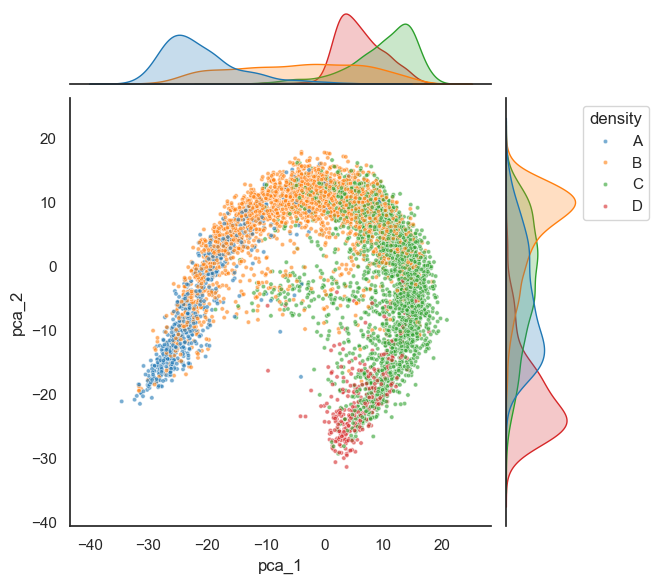

In [30]:
plot_joint(df, 'density', x, y, color_palette)

### Interactive visualisation

With the code below you can interactively explore the latent space to better understand how samples are distributed. You can modify the code to overlay different types of meta information.

In [31]:
df["image_path"] = [
    os.path.join("images", str(df.study_id.values[idx]), str(df.image_id.values[idx]) + ".png")
    for idx in range(len(df))
]

df['color_label'] = 0
df.loc[df['density'] == 'A', 'color_label'] = 0
df.loc[df['density'] == 'B', 'color_label'] = 1
df.loc[df['density'] == 'C', 'color_label'] = 2
df.loc[df['density'] == 'D', 'color_label'] = 3

In [32]:
def rgb_to_hex(rgb):
    return '#{:02x}{:02x}{:02x}'.format(rgb[0], rgb[1], rgb[2])

color = cm.tab10(np.linspace(0, 1, 10))
colorlist = [(np.array(mpl.colors.to_rgb(c))*255).astype(int).tolist() for c in color]*10

colors = [rgb_to_hex(colorlist[c]) for c in df.color_label.values]

In [33]:
def preprocess(image):
    # breast mask
    image_norm = image - np.min(image)
    image_norm = image_norm / np.max(image_norm)
    thresh = cv2.threshold(img_as_ubyte(image_norm), 5, 255, cv2.THRESH_BINARY)[1]

    # Connected components with stats.
    nb_components, output, stats, _ = cv2.connectedComponentsWithStats(thresh, connectivity=4)

    # Find the largest non background component.
    # Note: range() starts from 1 since 0 is the background label.
    max_label, _ = max(
        [(i, stats[i, cv2.CC_STAT_AREA]) for i in range(1, nb_components)],
        key=lambda x: x[1],
    )
    mask = output == max_label
    image_masked = image.copy()
    image_masked[mask == 0] = 0

    return image_masked

In [34]:
out = Output()
@out.capture(clear_output=True)
def handle_click(trace, points, state):
    sample = df.iloc[points.point_inds[0]]
    img_orig = imread(os.path.join(DATA_DIR, sample.image_path))
    img_proc = preprocess(img_orig)
    
    s = [6] * len(df)
    for i in points.point_inds:
        s[i] = 12
    with fig.batch_update():
        scatter.marker.size = s

    f, (ax1, ax2) = plt.subplots(1,2, figsize=(8,8))
    ax1.imshow(img_orig, cmap='gray')
    ax1.set_title('original')
    ax1.axis('off')
    ax2.imshow(img_proc, cmap='gray')
    ax2.set_title('processed')
    ax2.axis('off')
    plt.show(f)
    
fig = go.FigureWidget(px.scatter(df, x=x, y=y, template='simple_white', hover_data={'density': True, x:False, y:False}))
fig.update_layout(width=600, height=600)
scatter = fig.data[0]
scatter.on_click(handle_click)
scatter.marker.size = [6] * len(df)
scatter.marker.color = colors

HBox([fig, out])

    'data': [{'customdata': array([['B'],
                                   ['B…